In [1]:
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face, fixed_image_standardization
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from tqdm.notebook import tqdm
import cv2

In [2]:
root = '../data/lfw/'
paths = []
for folder in os.listdir(root):
    person = os.path.join(root, folder)
    photo = os.listdir(person)[0]
    paths.append(os.path.join(person,photo))
print(f"There are {len(paths)} photos")

There are 5752 photos


In [3]:
device = torch.device('cuda')
mtcnn = MTCNN(keep_all=False, device=device)
resnet = InceptionResnetV1(pretrained='vggface2').eval().cuda()

In [4]:
embedding_groups = []
batch_size = 256
n = len(paths)
nbatches = np.ceil(n/batch_size).astype('int')
for i in tqdm(range(nbatches)):
    start = i * batch_size
    end = min(start + batch_size, n)
    batch_input = [Image.open(path) for path in paths[start:end]]
    batch_cropped = mtcnn(batch_input)
    batch_cropped = torch.cat([ img.unsqueeze(0) for img in batch_cropped ])
    # here img_cropped is a tensor of shape [n, 3, 160, 160] on the device cpu

    # get embeddings using resnet
    with torch.no_grad():
        # copy input tensor to gpu
        batch_cropped = batch_cropped.cuda()

        # make forward passs on the model
        embeddings = resnet(batch_cropped)

        # copy to cpu and convert output to numpy
        embeddings_numpy = embeddings.cpu().numpy()
        assert(embeddings.is_cuda)
        del(embeddings)
    # get the maximum distance between two embeddings under the same name
    embedding_groups.append(embeddings_numpy)
    torch.cuda.empty_cache()

In [5]:
embeddings = np.concatenate(embedding_groups)

In [15]:
np.save('embeddings', embeddings)
np.save('paths', np.array(paths))

In [6]:
def crop_display(path):
    img = Image.open(path)
    boxes, probs, points = mtcnn.detect(img, landmarks=True)
    img_draw = img.copy()
    draw = ImageDraw.Draw(img_draw)
    embeds = []
    for box in boxes:
        draw.rectangle(box, outline=(255, 0, 0), width=6)
        resized = extract_face(img, box).unsqueeze(0)
        resized = fixed_image_standardization(resized)
        with torch.no_grad():
            embedding = resnet(torch.Tensor(resized).cuda()).cpu().numpy()
        embeds.append(embedding)
    return img_draw, embeds

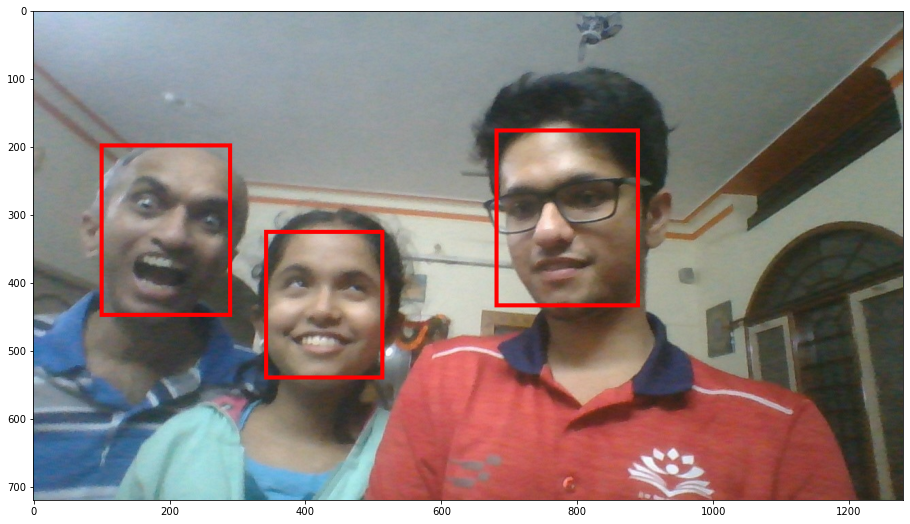

In [9]:
img, embeds = crop_display('../../Pictures/Camera Roll/camera.jpg')
plt.figure(figsize=(18,9))
plt.imshow(img)

In [11]:
face_paths = []
for e in embeds:
    dists = np.linalg.norm(embeddings - e, axis=1)
    i = dists.argmin()
    print(paths[i], dists[i])
    face_paths.append(paths[i])

../data/lfw/Deepak\deepak.jpg 0.81234646
../data/lfw/Ramachandra\ramu.jpg 0.801533
../data/lfw/Bhoomika\bhoomi.jpg 0.5414091


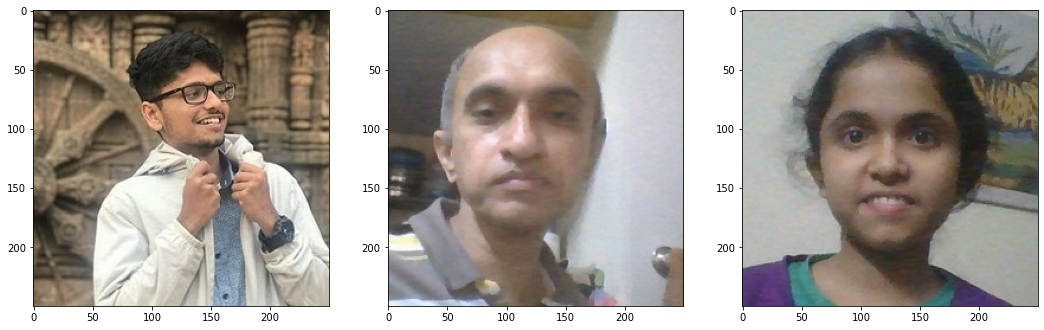

In [12]:
fig, axs = plt.subplots(1,3,figsize=(18,6))
for i in range(3):
    axs[i].imshow(Image.open(face_paths[i]))